In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt

2023-05-15 02:43:27,014 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
SEED = 69

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

In [3]:
data = pd.read_parquet("data/data_with_feats_4xgb.parquet.gzip")

In [4]:
target_cols = [col for col in data.columns if "target" in col] + ['term']
target_cols

['target', 'target_month', 'target_xgb', 'term']

In [5]:
features = ["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate", "revol_util"]

features += [col for col in data.columns if "home_ownership_ohe_" in col]

data_used_cols = data[features + target_cols].dropna()
# assert data.shape[0] == data_used_cols.shape[0]

features

['annual_inc',
 'loan_amnt',
 'fico_average',
 'emp_length',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'sub_grade',
 'int_rate',
 'revol_util',
 'home_ownership_ohe_ANY',
 'home_ownership_ohe_MORTGAGE',
 'home_ownership_ohe_NONE',
 'home_ownership_ohe_OTHER',
 'home_ownership_ohe_OWN',
 'home_ownership_ohe_RENT']

In [6]:
data["target_xgb"].value_counts()

0    1723625
1     133750
Name: target_xgb, dtype: int64

In [7]:
data_true = data_used_cols.loc[data_used_cols["target_xgb"] == 1]
data_false = data_used_cols.loc[data_used_cols["target_xgb"] == 0]

In [8]:
X, y = data_false[features], data_false[target_cols]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.6, random_state=SEED)

In [9]:
X_train_val = pd.concat([X_train_val, data_true[features]], axis=0)
y_train_val = pd.concat([y_train_val, data_true[target_cols]], axis=0)

In [10]:
(y_train_val["target_xgb"] == 1).sum()

130489

# Predict

In [11]:
def get_proba_for_month(proba, n_months):
    # PDn = 1 - (1-pd12)^(n/12)

    return 1 - (1 - proba) ** (n_months / 12)
    

In [15]:
def objective(trial):

    VERBOSE_PLOTS = True
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 5000,
        'subsample': trial.suggest_float('subsample', 0.25, 0.7, log=True),
        'min_child_weight': 30,
        'early_stopping_rounds': 10,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10, log=True),
        'seed': SEED,
    }

    # Train and test model on each fold
    metrics = []
    for train_index, val_index in list(skf.split(X_train_val, y_train_val["target_xgb"]))[:3]:
        X_train, X_val = X_train_val.iloc[train_index].copy(), X_train_val.iloc[val_index].copy()
        y_train, y_val = y_train_val.iloc[train_index].copy(), y_train_val.iloc[val_index].copy()
        
        # Train model
        params['scale_pos_weight'] = (y_train["target_xgb"] == 0).sum() / (y_train["target_xgb"] == 1).sum()

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train["target_xgb"], 
            eval_set=[(X_train, y_train["target_xgb"]), (X_val, y_val["target_xgb"])],
            verbose=False
        )

        if VERBOSE_PLOTS:
            print(params, features)
            results = model.evals_result()
            epochs = len(results['validation_0']['auc'])
            x_axis = range(0, epochs)
            fig, ax = plt.subplots()
            ax.plot(x_axis, results['validation_0']['auc'], label='Train')
            ax.plot(x_axis, results['validation_1']['auc'], label='Test')
            ax.legend()
            plt.ylabel('AUC')
            plt.title('XGBoost AUC')
            plt.show()
    
        # Test model
        
        y_val['y_pred'] = model.predict_proba(X_val)[:,1]
        y_val['prob_for_month'] = y_val.apply(lambda x: get_proba_for_month(x.y_pred, x.term), axis=1)

        c_ind = concordance_index(
            event_times=y_val["target_month"], predicted_scores=-y_val['prob_for_month'], event_observed=y_val['target']
        )

        print("C_INDEX", c_ind)
        metric = roc_auc_score(y_val["target_xgb"], y_val['y_pred'])
        metrics.append(
            metric
        )
        print(
            round(
                metric, 5
            )
        )

        if len(metrics) == 2 and max(metrics) < 0.72:
            break
        
    # print(
    #     f"{round(np.mean(metrics), 5)} +- {round(np.std(metrics), 5)}"
    # )

    return np.mean(metrics)

[I 2023-05-15 02:47:10,415] A new study created in memory with name: no-name-3adef0a7-3c6f-4de8-baf0-e4a986e82943


{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.41225290934179437, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.044034297197613016, 'max_depth': 5, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


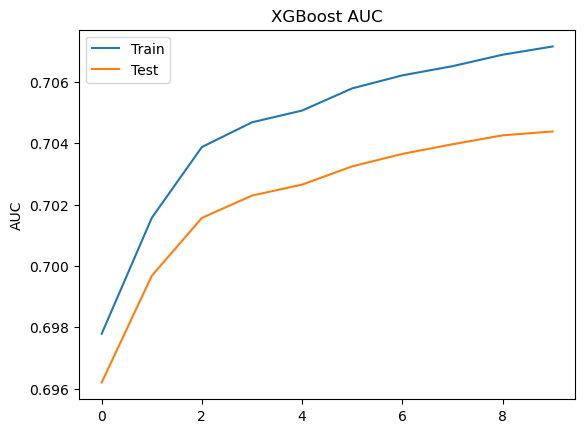

C_INDEX 0.6567904616094817
0.70438
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.41225290934179437, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.044034297197613016, 'max_depth': 5, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


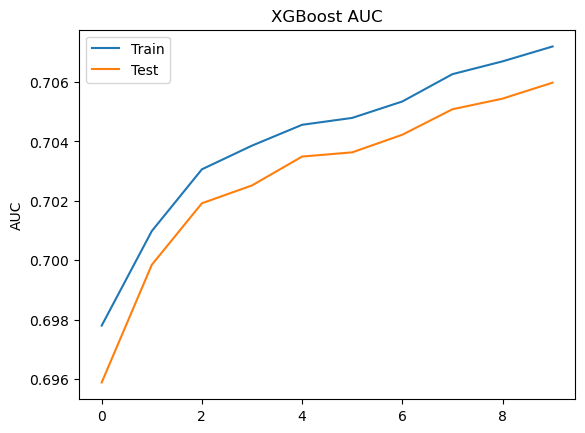

[I 2023-05-15 02:47:21,871] Trial 0 finished with value: 0.7051794244449493 and parameters: {'subsample': 0.41225290934179437, 'learning_rate': 0.044034297197613016, 'max_depth': 5}. Best is trial 0 with value: 0.7051794244449493.


C_INDEX 0.6575305616604766
0.70598
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.5748183823995926, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.03309685259235718, 'max_depth': 5, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


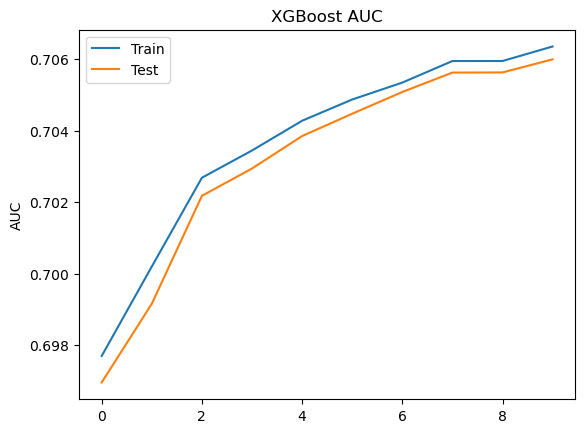

C_INDEX 0.6568425620145077
0.70599
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.5748183823995926, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.03309685259235718, 'max_depth': 5, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


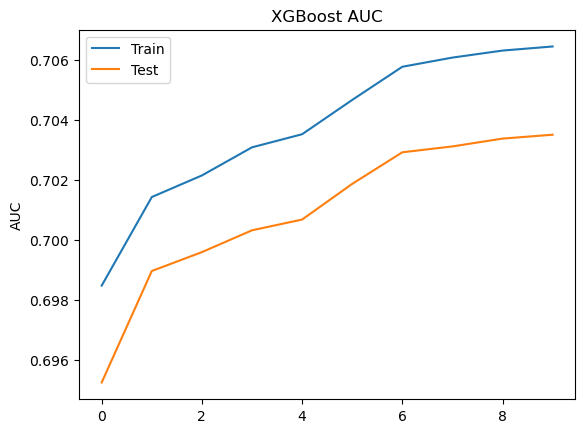

[I 2023-05-15 02:47:33,193] Trial 1 finished with value: 0.7047492860955489 and parameters: {'subsample': 0.5748183823995926, 'learning_rate': 0.03309685259235718, 'max_depth': 5}. Best is trial 0 with value: 0.7051794244449493.


C_INDEX 0.6561691303137007
0.7035
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.26929091554706086, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.026497695019986438, 'max_depth': 9, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


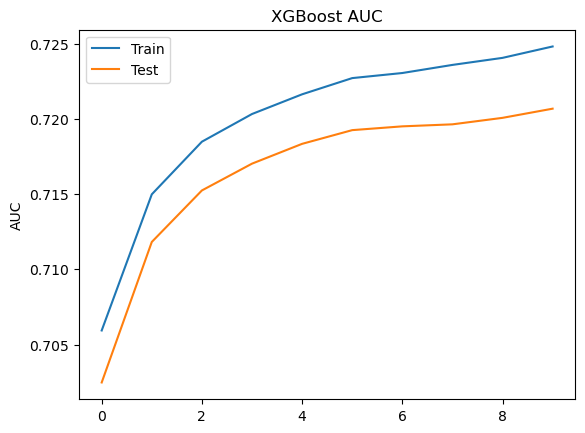

C_INDEX 0.662449620852336
0.72068
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.26929091554706086, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.026497695019986438, 'max_depth': 9, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


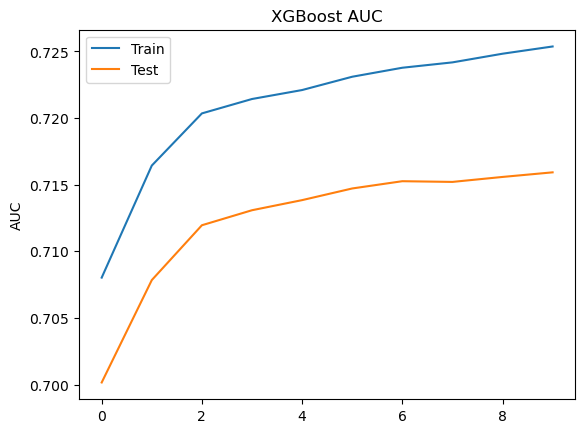

C_INDEX 0.6609482226424915
0.71592
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.26929091554706086, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.026497695019986438, 'max_depth': 9, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


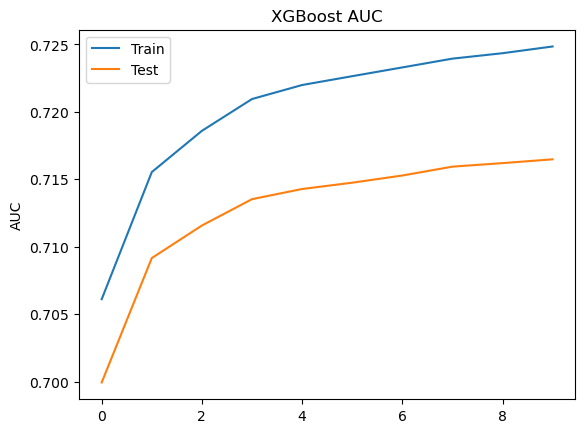

[I 2023-05-15 02:47:55,152] Trial 2 finished with value: 0.7176951884075629 and parameters: {'subsample': 0.26929091554706086, 'learning_rate': 0.026497695019986438, 'max_depth': 9}. Best is trial 2 with value: 0.7176951884075629.


C_INDEX 0.6620980497112735
0.71648
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.6346160654760435, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.17186767273704975, 'max_depth': 3, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


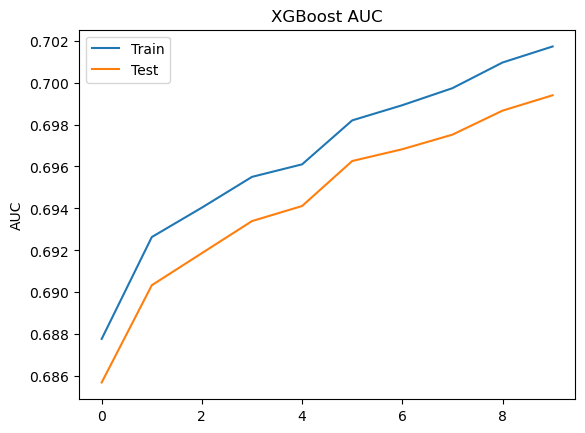

C_INDEX 0.6653786606551555
0.6994
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.6346160654760435, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.17186767273704975, 'max_depth': 3, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


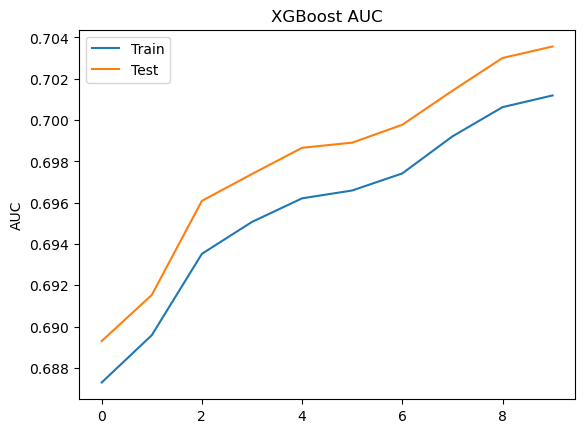

[I 2023-05-15 02:48:05,141] Trial 3 finished with value: 0.701479371246402 and parameters: {'subsample': 0.6346160654760435, 'learning_rate': 0.17186767273704975, 'max_depth': 3}. Best is trial 2 with value: 0.7176951884075629.


C_INDEX 0.666474289056784
0.70356
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.5687939296473674, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.0464016088408974, 'max_depth': 10, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


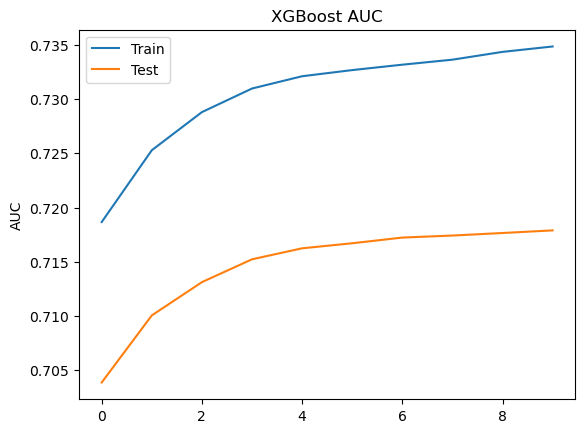

C_INDEX 0.6626132962665755
0.7179
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.5687939296473674, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.0464016088408974, 'max_depth': 10, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


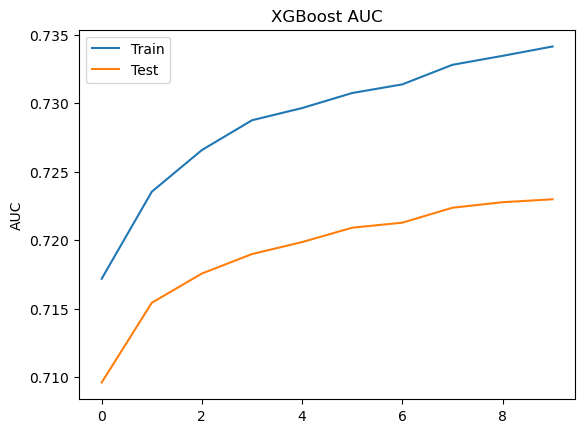

C_INDEX 0.6653743754790746
0.72299
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.5687939296473674, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.0464016088408974, 'max_depth': 10, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


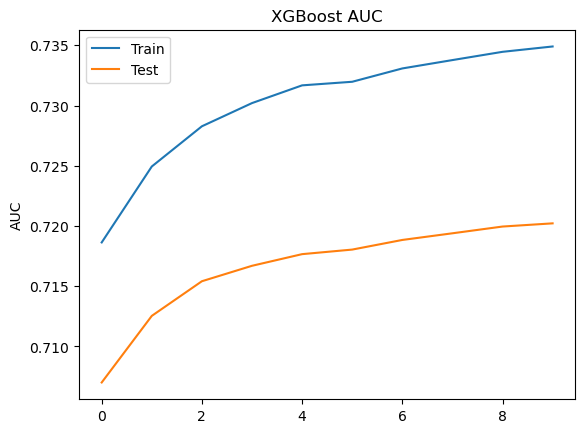

[I 2023-05-15 02:48:31,851] Trial 4 finished with value: 0.720366395594907 and parameters: {'subsample': 0.5687939296473674, 'learning_rate': 0.0464016088408974, 'max_depth': 10}. Best is trial 4 with value: 0.720366395594907.


C_INDEX 0.6658258221546243
0.72022
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.3355682465460187, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.10880182854641392, 'max_depth': 4, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


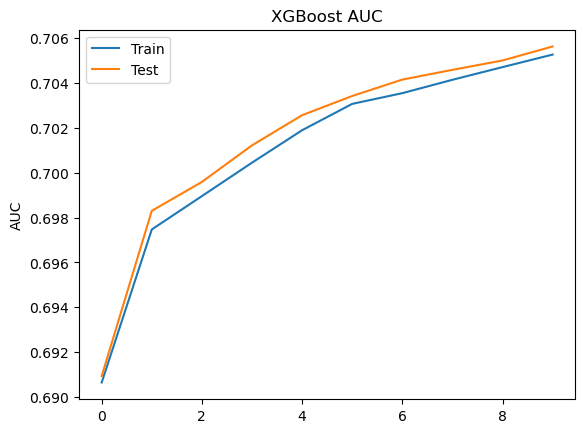

C_INDEX 0.665117022164552
0.70563
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 10, 'subsample': 0.3355682465460187, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.10880182854641392, 'max_depth': 4, 'seed': 69, 'scale_pos_weight': 5.082928604956366} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


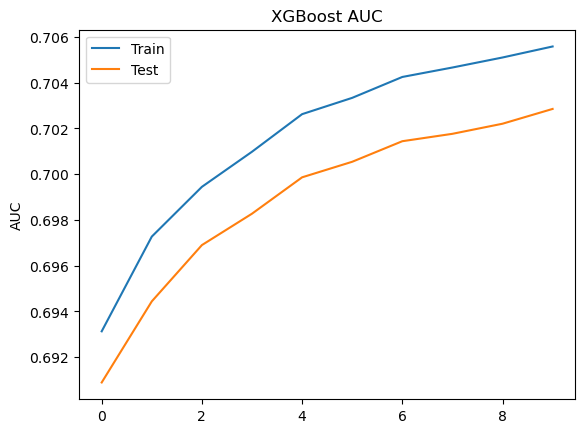

[I 2023-05-15 02:48:42,738] Trial 5 finished with value: 0.7042411013950541 and parameters: {'subsample': 0.3355682465460187, 'learning_rate': 0.10880182854641392, 'max_depth': 4}. Best is trial 4 with value: 0.720366395594907.


C_INDEX 0.6629180323756411
0.70285


In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)

In [14]:
study.best_trial

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.7169963113722784], datetime_start=datetime.datetime(2023, 5, 15, 2, 44, 30, 686156), datetime_complete=datetime.datetime(2023, 5, 15, 2, 44, 47, 264880), params={'subsample': 0.5518849622643741, 'learning_rate': 0.011264272006726727, 'max_depth': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=0.7, log=True, low=0.25, step=None), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=True, low=3, step=1)}, trial_id=5, value=None)

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5706904511659537], datetime_start=datetime.datetime(2023, 5, 13, 18, 25, 38, 19301), datetime_complete=datetime.datetime(2023, 5, 13, 18, 27, 1, 321098), params={'subsample': 0.06435314059498777, 'learning_rate': 0.036202388856127116}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5841330582073612], datetime_start=datetime.datetime(2023, 5, 13, 18, 34, 44, 410982), datetime_complete=datetime.datetime(2023, 5, 13, 18, 36, 35, 19502), params={'subsample': 0.6701497743342159, 'learning_rate': 0.18413715344103385}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.6288033226144973], datetime_start=datetime.datetime(2023, 5, 13, 19, 37, 31, 754674), datetime_complete=datetime.datetime(2023, 5, 13, 19, 39, 37, 640029), params={'subsample': 0.36848188910366186, 'learning_rate': 0.0314119110035605, 'features': ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length')}, user_attrs={}, system_attrs={}, intermediate_values={}, 

distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'features': CategoricalDistribution(choices=(('annual_inc', 'loan_amnt'), ('annual_inc', 'loan_amnt', 'fico_average'), ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length')))}, trial_id=18, value=None)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.6414780581888492], datetime_start=datetime.datetime(2023, 5, 13, 20, 4, 14, 72369), datetime_complete=datetime.datetime(2023, 5, 13, 20, 5, 23, 355636), params={'subsample': 0.22582945179691508, 'learning_rate': 0.014041463069293294}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=0, value=None)

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.6478027939799046], datetime_start=datetime.datetime(2023, 5, 13, 20, 43, 15, 532172), datetime_complete=datetime.datetime(2023, 5, 13, 20, 48, 4, 931532), params={'n_estimators': 297, 'subsample': 0.5023651754403868, 'learning_rate': 0.013297707588788659}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=600, log=True, low=100, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=4, value=None)

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7056628191146204], datetime_start=datetime.datetime(2023, 5, 13, 20, 57, 13, 758039), datetime_complete=datetime.datetime(2023, 5, 13, 21, 3, 26, 599971), params={'n_estimators': 386, 'subsample': 0.5802227354327434, 'learning_rate': 0.018175234298120842}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=400, log=True, low=150, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate"]

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7319637194257594], datetime_start=datetime.datetime(2023, 5, 14, 20, 37, 11, 356350), datetime_complete=datetime.datetime(2023, 5, 14, 20, 40, 40, 309404), params={'subsample': 0.5036186170641379, 'learning_rate': 0.07280828054330878, 'max_depth': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=0.6, log=True, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=True, low=3, step=1)}, trial_id=2, value=None)

features = ["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate", "revol_util"]
features += [col for col in data.columns if "home_ownership_ohe_" in col]

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.7338525205589255], datetime_start=datetime.datetime(2023, 5, 14, 21, 52, 16, 244266), datetime_complete=datetime.datetime(2023, 5, 14, 22, 1, 47, 415475), params={'subsample': 0.2619685319453447, 'learning_rate': 0.01739293623497205, 'max_depth': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=0.7, log=True, low=0.25, step=None), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=True, low=3, step=1)}, trial_id=4, value=None)

# Wrong

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "dti"]

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7042695763788417], datetime_start=datetime.datetime(2023, 5, 13, 21, 23, 14, 409457), datetime_complete=datetime.datetime(2023, 5, 13, 21, 26, 2, 806772), params={'n_estimators': 195, 'subsample': 0.050919411040719585, 'learning_rate': 0.02744129835382001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=True, low=150, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)



["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "initial_list_status"]

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.7055814865786371], datetime_start=datetime.datetime(2023, 5, 13, 22, 0, 25, 924283), datetime_complete=datetime.datetime(2023, 5, 13, 22, 6, 5, 514102), params={'n_estimators': 369, 'subsample': 0.5376649220043659, 'learning_rate': 0.049542498705915004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=True, low=150, step=1), 'subsample': FloatDistribution(high=0.6, log=True, low=0.05, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=4, value=None)

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "initial_list_status"]